In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pyedflib

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Imports réussis!")


Imports réussis!


In [7]:
# Vérifier le dataset téléchargé
data_dir = Path('../data/raw')

psg_files = sorted(data_dir.glob("*-PSG.edf"))
hypno_files = sorted(data_dir.glob("*-Hypnogram.edf"))

print(f"Dataset Sleep-EDF téléchargé:")
print(f"   PSG (signaux): {len(psg_files)}")
print(f"   Hypnogrammes (labels): {len(hypno_files)}")

# Extraire les IDs de base (SC4XXX)
def extract_base_id(filename):
    """Extrait l'ID de base (ex: SC4001 depuis SC4001E0-PSG.edf)"""
    stem = filename.stem  # SC4001E0-PSG
    # Prendre les 6 premiers caractères (SC4001)
    return stem[:6]

psg_base_ids = {extract_base_id(f): f for f in psg_files}
hypno_base_ids = {extract_base_id(f): f for f in hypno_files}

# Trouver les correspondances
complete_ids = sorted(set(psg_base_ids.keys()) & set(hypno_base_ids.keys()))

print(f"\n Paires complètes (PSG + Hypno): {len(complete_ids)}")
print(f"IDs: {complete_ids[:5]}... ({len(complete_ids)} au total)")

# Afficher quelques exemples de paires
print(f"\n Exemples de paires:")
for base_id in complete_ids[:3]:
    print(f"   {base_id}:")
    print(f"      PSG:   {psg_base_ids[base_id].name}")
    print(f"      Hypno: {hypno_base_ids[base_id].name}")

if len(complete_ids) >= 20:
    print(f"\n Excellent! {len(complete_ids)} paires - Dataset parfait pour le modèle!")
elif len(complete_ids) >= 10:
    print(f"\n Bien! {len(complete_ids)} paires - Suffisant pour un MVP!")
    
# Sauvegarder pour utilisation dans les cellules suivantes
complete_pairs = {
    base_id: {
        'psg': psg_base_ids[base_id],
        'hypno': hypno_base_ids[base_id]
    }
    for base_id in complete_ids
}

Dataset Sleep-EDF téléchargé:
   PSG (signaux): 30
   Hypnogrammes (labels): 28

 Paires complètes (PSG + Hypno): 28
IDs: ['SC4001', 'SC4002', 'SC4011', 'SC4012', 'SC4021']... (28 au total)

 Exemples de paires:
   SC4001:
      PSG:   SC4001E0-PSG.edf
      Hypno: SC4001EC-Hypnogram.edf
   SC4002:
      PSG:   SC4002E0-PSG.edf
      Hypno: SC4002EC-Hypnogram.edf
   SC4011:
      PSG:   SC4011E0-PSG.edf
      Hypno: SC4011EH-Hypnogram.edf

 Excellent! 28 paires - Dataset parfait pour le modèle!


In [8]:
# Charger un exemple de fichier PSG (la première paire complète)
first_id = complete_ids[0]
example_psg = complete_pairs[first_id]['psg']

print(f" Paire sélectionnée: {first_id}")
print(f"   PSG: {example_psg.name}\n")

with pyedflib.EdfReader(str(example_psg)) as f:
    # Métadonnées
    n_channels = f.signals_in_file
    labels = f.getSignalLabels()
    duration = f.getFileDuration()
    sample_freq = f.getSampleFrequency(0)
    
    # Charger le signal EEG (canal 0 = Fpz-Cz)
    eeg_signal = f.readSignal(0)

print(f" Informations du fichier:")
print(f"   Nombre de canaux: {n_channels}")
print(f"   Canaux disponibles: {labels}")
print(f"   Durée totale: {duration/3600:.2f} heures ({duration:.0f} secondes)")
print(f"   Fréquence d'échantillonnage: {sample_freq} Hz")
print(f"   Points de données EEG: {len(eeg_signal):,}")
print(f"\n Signal EEG chargé avec succès!")

 Paire sélectionnée: SC4001
   PSG: SC4001E0-PSG.edf

 Informations du fichier:
   Nombre de canaux: 7
   Canaux disponibles: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
   Durée totale: 22.08 heures (79500 secondes)
   Fréquence d'échantillonnage: 100.0 Hz
   Points de données EEG: 7,950,000

 Signal EEG chargé avec succès!


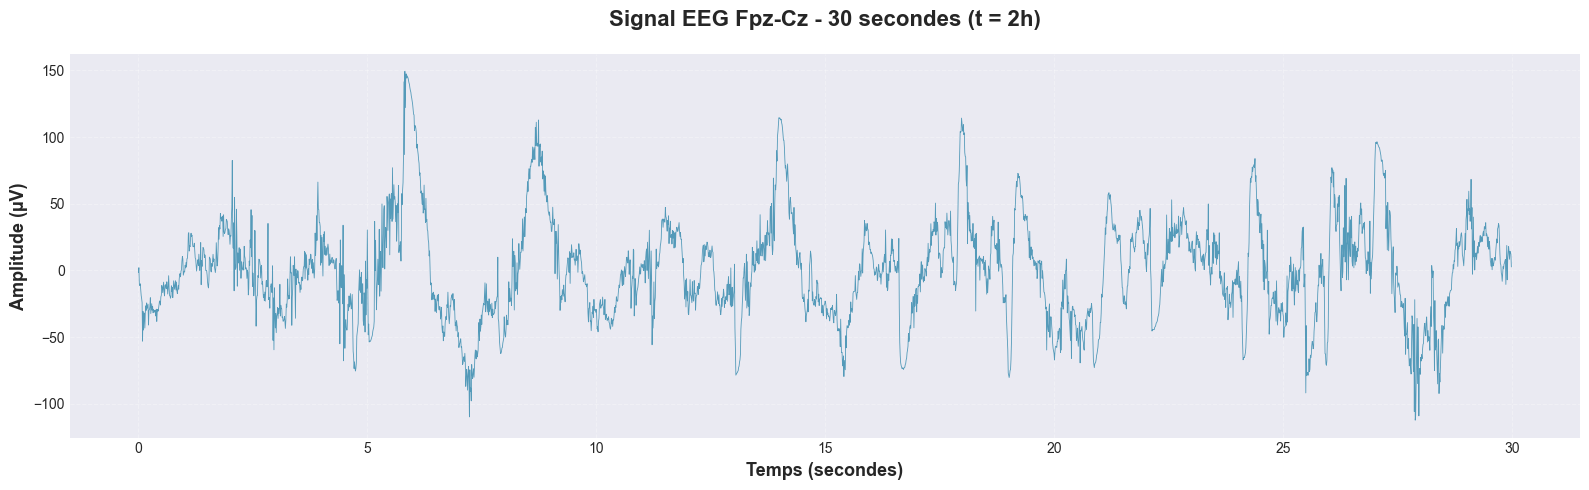

 Segment affiché: 30s à partir de 2.0h
 Amplitude min: -112.39 µV
 Amplitude max: 149.33 µV


In [9]:
# Visualiser 30 secondes de signal EEG
# On prend un moment après 2h de sommeil (patient probablement endormi)

start_time = 2 * 3600  # 2 heures après le début
duration_viz = 30       # 30 secondes
fs = 100                # Fréquence échantillonnage

start_idx = int(start_time * fs)
end_idx = int(start_idx + duration_viz * fs)

signal_segment = eeg_signal[start_idx:end_idx]
time_axis = np.arange(len(signal_segment)) / fs

# Créer le graphique
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(time_axis, signal_segment, linewidth=0.6, color='#2E86AB', alpha=0.8)
ax.set_title(f'Signal EEG Fpz-Cz - 30 secondes (t = {start_time/3600:.0f}h)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Temps (secondes)', fontsize=13, fontweight='bold')
ax.set_ylabel('Amplitude (µV)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print(f" Segment affiché: {duration_viz}s à partir de {start_time/3600:.1f}h")
print(f" Amplitude min: {signal_segment.min():.2f} µV")
print(f" Amplitude max: {signal_segment.max():.2f} µV")

In [10]:
# Charger l'hypnogramme correspondant
hypno_file = complete_pairs[first_id]['hypno']

print(f"📂 Hypnogramme: {hypno_file.name}\n")

# Charger les annotations
with pyedflib.EdfReader(str(hypno_file)) as f:
    annotations = f.readAnnotations()

# Créer un DataFrame
stages_data = []
for onset, duration, description in zip(*annotations):
    stages_data.append({
        'onset': onset,
        'duration': duration,
        'stage': description
    })

df_stages = pd.DataFrame(stages_data)

print(f" Annotations chargées: {len(df_stages)} époques de 30s")
print(f"   Durée totale: {df_stages['duration'].sum()/3600:.2f} heures\n")

# Distribution des stades
print(f" Distribution des stades de sommeil:\n")
stage_counts = df_stages['stage'].value_counts()
for stage, count in stage_counts.items():
    percentage = (count / len(df_stages)) * 100
    print(f"   {stage:25s}: {count:4d} époques ({percentage:5.1f}%)")

📂 Hypnogramme: SC4001EC-Hypnogram.edf

 Annotations chargées: 154 époques de 30s
   Durée totale: 24.00 heures

 Distribution des stades de sommeil:

   Sleep stage 3            :   48 époques ( 31.2%)
   Sleep stage 2            :   40 époques ( 26.0%)
   Sleep stage 1            :   24 époques ( 15.6%)
   Sleep stage 4            :   23 époques ( 14.9%)
   Sleep stage W            :   12 époques (  7.8%)
   Sleep stage R            :    6 époques (  3.9%)
   Sleep stage ?            :    1 époques (  0.6%)


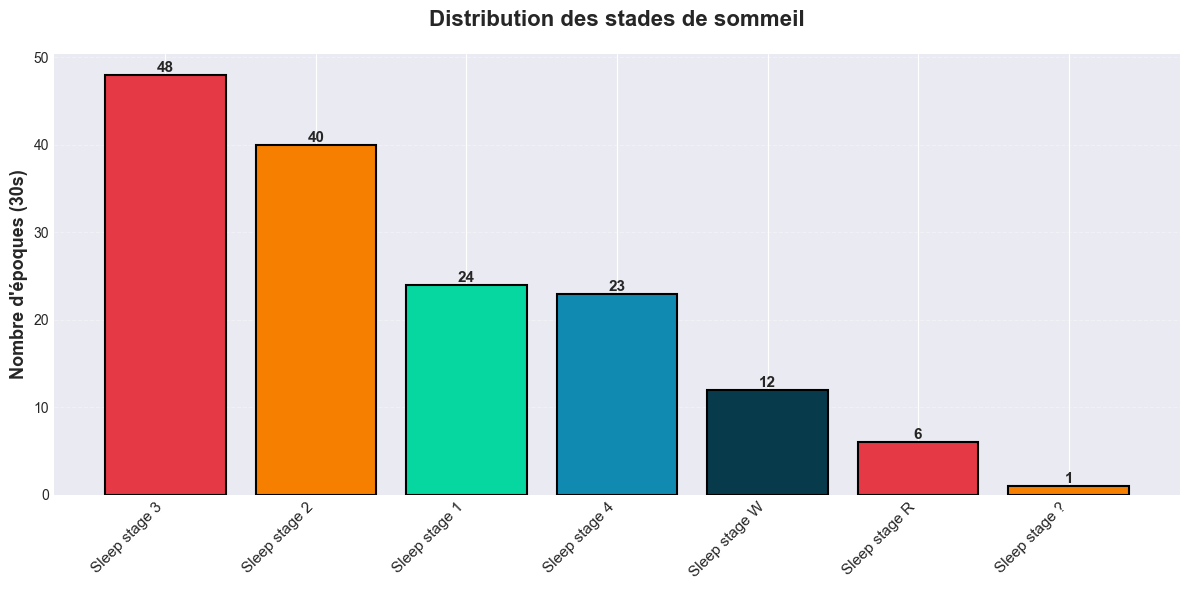

Graphique généré!


In [11]:
# Visualiser la distribution des stades
fig, ax = plt.subplots(figsize=(12, 6))

stage_counts = df_stages['stage'].value_counts()
colors = ['#E63946', '#F77F00', '#06D6A0', '#118AB2', '#073B4C']

bars = ax.bar(range(len(stage_counts)), stage_counts.values, 
              color=colors[:len(stage_counts)], edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(stage_counts)))
ax.set_xticklabels(stage_counts.index, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Nombre d\'époques (30s)', fontsize=13, fontweight='bold')
ax.set_title('Distribution des stades de sommeil', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Graphique généré!")

🔍 AUDIT COMPLET DU DATASET

📊 STATISTIQUES GLOBALES (28 enregistrements)
       PSG_duration_h  Hypno_epochs  Hypno_duration_h  Coverage_%
count       28.000000     28.000000              28.0   28.000000
mean        23.021429    134.285714              24.0  104.329558
std          0.635472     29.011948               0.0    2.963932
min         21.416667     63.000000              24.0  100.769769
25%         22.745833    118.750000              24.0  102.454681
50%         23.191667    130.500000              24.0  103.485568
75%         23.425000    154.500000              24.0  105.514096
max         23.816667    179.000000              24.0  112.062257

⚠️  ENREGISTREMENTS SUSPECTS (couverture < 80% ou durée anormale)
        ID  PSG_duration_h  Hypno_epochs  Coverage_%
0   SC4001       22.083333           154  108.679245
1   SC4002       23.583333           152  101.766784
2   SC4011       23.350000           126  102.783726
3   SC4012       23.750000           171  101.052632
4

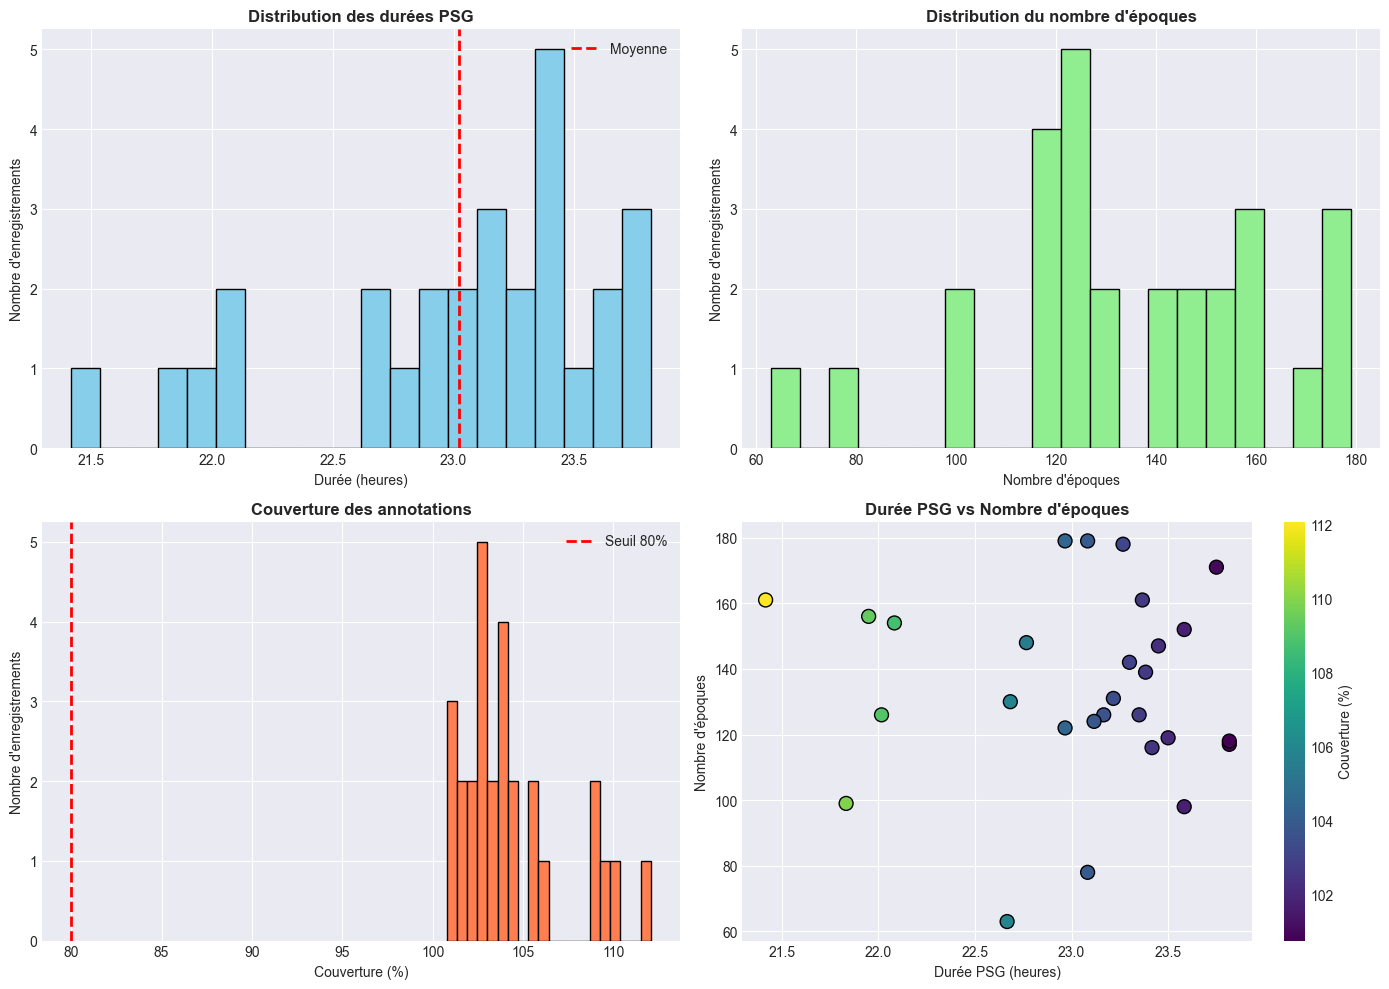


✅ Audit terminé!

📊 DATASET NETTOYÉ:
   - Avant: 28 enregistrements
   - Après: 28 enregistrements (couverture ≥ 80%)
   - Rejetés: 0


In [12]:
# Vérification complète du dataset - Qualité des données
print("🔍 AUDIT COMPLET DU DATASET")
print("="*70)

stats_list = []

for base_id in complete_ids:
    psg_file = complete_pairs[base_id]['psg']
    hypno_file = complete_pairs[base_id]['hypno']
    
    try:
        # Charger PSG
        with pyedflib.EdfReader(str(psg_file)) as f:
            psg_duration = f.getFileDuration()
        
        # Charger Hypnogramme
        with pyedflib.EdfReader(str(hypno_file)) as f:
            annotations = f.readAnnotations()
            
        # Calculer stats
        n_epochs = len(annotations[0])
        hypno_duration = sum(annotations[1])  # Durée totale annotée
        
        stats_list.append({
            'ID': base_id,
            'PSG_duration_h': psg_duration / 3600,
            'Hypno_epochs': n_epochs,
            'Hypno_duration_h': hypno_duration / 3600,
            'Coverage_%': (hypno_duration / psg_duration) * 100
        })
        
    except Exception as e:
        print(f"⚠️  Erreur pour {base_id}: {e}")

# Créer DataFrame
df_stats = pd.DataFrame(stats_list)

print(f"\n📊 STATISTIQUES GLOBALES ({len(df_stats)} enregistrements)")
print("="*70)
print(df_stats[['PSG_duration_h', 'Hypno_epochs', 'Hypno_duration_h', 'Coverage_%']].describe())

print(f"\n⚠️  ENREGISTREMENTS SUSPECTS (couverture < 80% ou durée anormale)")
print("="*70)
suspects = df_stats[(df_stats['Coverage_%'] < 80) | 
                    (df_stats['PSG_duration_h'] < 6) | 
                    (df_stats['PSG_duration_h'] > 10)]

if len(suspects) > 0:
    print(suspects[['ID', 'PSG_duration_h', 'Hypno_epochs', 'Coverage_%']])
    print(f"\n⚠️  {len(suspects)} enregistrements suspects détectés")
else:
    print("✅ Tous les enregistrements sont dans les normes!")

print(f"\n📈 DISTRIBUTION DES DURÉES")
print("="*70)
print(f"Durée PSG moyenne: {df_stats['PSG_duration_h'].mean():.2f}h")
print(f"Durée PSG min: {df_stats['PSG_duration_h'].min():.2f}h")
print(f"Durée PSG max: {df_stats['PSG_duration_h'].max():.2f}h")
print(f"\nNombre d'époques moyen: {df_stats['Hypno_epochs'].mean():.0f}")
print(f"Couverture moyenne: {df_stats['Coverage_%'].mean():.1f}%")

# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Durée PSG
axes[0, 0].hist(df_stats['PSG_duration_h'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution des durées PSG', fontweight='bold')
axes[0, 0].set_xlabel('Durée (heures)')
axes[0, 0].set_ylabel('Nombre d\'enregistrements')
axes[0, 0].axvline(df_stats['PSG_duration_h'].mean(), color='red', 
                   linestyle='--', linewidth=2, label='Moyenne')
axes[0, 0].legend()

# Nombre d'époques
axes[0, 1].hist(df_stats['Hypno_epochs'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution du nombre d\'époques', fontweight='bold')
axes[0, 1].set_xlabel('Nombre d\'époques')
axes[0, 1].set_ylabel('Nombre d\'enregistrements')

# Couverture
axes[1, 0].hist(df_stats['Coverage_%'], bins=20, color='coral', edgecolor='black')
axes[1, 0].set_title('Couverture des annotations', fontweight='bold')
axes[1, 0].set_xlabel('Couverture (%)')
axes[1, 0].set_ylabel('Nombre d\'enregistrements')
axes[1, 0].axvline(80, color='red', linestyle='--', linewidth=2, label='Seuil 80%')
axes[1, 0].legend()

# Scatter: Durée vs Époques
axes[1, 1].scatter(df_stats['PSG_duration_h'], df_stats['Hypno_epochs'], 
                   c=df_stats['Coverage_%'], cmap='viridis', s=100, edgecolor='black')
axes[1, 1].set_title('Durée PSG vs Nombre d\'époques', fontweight='bold')
axes[1, 1].set_xlabel('Durée PSG (heures)')
axes[1, 1].set_ylabel('Nombre d\'époques')
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Couverture (%)')

plt.tight_layout()
plt.show()

print("\n✅ Audit terminé!")

# Sauvegarder les stats
df_stats_clean = df_stats[df_stats['Coverage_%'] >= 80]
print(f"\n📊 DATASET NETTOYÉ:")
print(f"   - Avant: {len(df_stats)} enregistrements")
print(f"   - Après: {len(df_stats_clean)} enregistrements (couverture ≥ 80%)")
print(f"   - Rejetés: {len(df_stats) - len(df_stats_clean)}")